Intro about predicting blueberry harvest.

# Set up data

In [1]:
from pathlib import Path
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import dtreeviz
from IPython.display import Image, display_svg, SVG

data_path = Path('./data')
df = pd.read_csv(data_path/'train.csv', low_memory=False)
df_test = pd.read_csv(data_path/'test.csv', low_memory=False)
df

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  \
0          0       25.0      0.50     0.25     0.75   0.50              69.7   
1          1       25.0      0.50     0.25     0.50   0.50              69.7   
2          2       12.5      0.25     0.25     0.63   0.63              86.0   
3          3       12.5      0.25     0.25     0.63   0.50              77.4   
4          4       25.0      0.50     0.25     0.63   0.63              77.4   
...      ...        ...       ...      ...      ...    ...               ...   
15284  15284       12.5      0.25     0.25     0.38   0.50              77.4   
15285  15285       12.5      0.25     0.25     0.25   0.50              86.0   
15286  15286       25.0      0.50     0.25     0.38   0.75              77.4   
15287  15287       25.0      0.50     0.25     0.63   0.63              69.7   
15288  15288       25.0      0.50     0.25     0.63   0.50              77.4   

       MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
0                  42.1                  58.2              50.2   
1                  42.1                  58.2              50.2   
2                  52.0                  71.9              62.0   
3                  46.8                  64.7              55.8   
4                  46.8                  64.7              55.8   
...                 ...                   ...               ...   
15284              46.8                  64.7              55.8   
15285              52.0                  71.9              62.0   
15286              46.8                  64.7              55.8   
15287              42.1                  58.2              50.2   
15288              46.8                  64.7              55.8   

       MinOfLowerTRange  AverageOfLowerTRange  RainingDays  \
0                  24.3                  41.2         24.0   
1                  24.3                  41.2         24.0   
2                  30.0                  50.8         24.0   
3                  27.0                  45.8         24.0   
4                  27.0                  45.8         24.0   
...                 ...                   ...          ...   
15284              27.0                  45.8         16.0   
15285              30.0                  50.8         34.0   
15286              27.0                  45.8         34.0   
15287              24.3                  41.2         24.0   
15288              27.0                  45.8         16.0   

       AverageRainingDays  fruitset  fruitmass      seeds       yield  
0                    0.39  0.425011   0.417545  32.460887  4476.81146  
1                    0.39  0.444908   0.422051  33.858317  5548.12201  
2                    0.39  0.552927   0.470853  38.341781  6869.77760  
3                    0.39  0.565976   0.478137  39.467561  6880.77590  
4                    0.39  0.579677   0.494165  40.484512  7479.93417  
...                   ...       ...        ...        ...         ...  
15284                0.26  0.556302   0.476308  40.546480  7667.83619  
15285                0.56  0.354413   0.388145  29.467434  3680.56025  
15286                0.56  0.422548   0.416786  32.299059  4696.44394  
15287                0.39  0.542170   0.434133  36.674243  6772.93347  
15288                0.26  0.492077   0.446576  35.094733  5867.99722  

[15289 rows x 18 columns]

# Data prep

In [2]:
df.columns
df_test.columns
[{df[i].name:df[i].unique()} for i in df.columns]

[{'id': array([    0,     1,     2, ..., 15286, 15287, 15288], dtype=int64)},
 {'clonesize': array([25. , 12.5, 37.5, 20. , 10. , 40. ])},
 {'honeybee': array([ 0.5  ,  0.25 ,  0.75 ,  0.537,  0.   , 18.43 ,  6.64 ])},
 {'bumbles': array([0.25 , 0.38 , 0.117, 0.058, 0.56 , 0.065, 0.   , 0.585, 0.042,
         0.293, 0.26 ])},
 {'andrena': array([0.75 , 0.5  , 0.63 , 0.38 , 0.25 , 0.409, 0.707, 0.   , 0.24 ,
         0.56 , 0.101, 0.49 , 0.234, 0.147, 0.235, 0.229])},
 {'osmia': array([0.5  , 0.63 , 0.75 , 0.25 , 0.38 , 0.058, 0.117, 0.62 , 0.585,
         0.   , 0.021, 0.02 , 0.078, 0.606])},
 {'MaxOfUpperTRange': array([69.7, 86. , 77.4, 94.6, 89. , 79. ])},
 {'MinOfUpperTRange': array([42.1, 52. , 46.8, 57.2, 39. ])},
 {'AverageOfUpperTRange': array([58.2, 71.9, 64.7, 79. , 65.6])},
 {'MaxOfLowerTRange': array([50.2, 62. , 55.8, 68.2, 66. , 52. ])},
 {'MinOfLowerTRange': array([24.3, 30. , 27. , 33. , 28. , 25. , 31. ])},
 {'AverageOfLowerTRange': array([41.2, 50.8, 45.8, 55.9, 45.3]

Based on how few unique values they contain, the first five columns might warrant treatment as categorical variables

In [3]:
df.clonesize = df.clonesize.astype('category')
df.honeybee = df.honeybee.astype('category')
df.bumbles = df.bumbles.astype('category')
df.andrena = df.andrena.astype('category')
df.osmia = df.osmia.astype('category')

The dependent variable we are predicting is yield, and procs are wrappers on Pandas that handle strings and missing data. This dataset does not contain strings bu the functionality are grouped together. `Categorify` is a `TabularProc` that replaces a column with a numeric categorical column. `FillMissing` is a `TabularProc` that replaces missing values with the median of the column, and creates a new Boolean column that is set to `True` for any row where the value was missing.

In [4]:
dep_var = 'yield'
procs = [Categorify, FillMissing]

Based on the structure of the dataset, we will randomly split the data into train and validation sets

In [5]:
rng = np.random.default_rng()
np.random.seed(11)
train_size = round(len(df) * .7)
train_idx = rng.integers(low=0, high=df.last_valid_index(), size=train_size)
splits = (list(train_idx), list(df.index[~train_idx]))

Tell TabularPandas which columns are continuous and categorical. Save the processed data for later use.

In [6]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
to.show(3)
save_pickle(data_path/'to.pkl',to)

# Creating decision trees
First define x and y, the independent and dependent variables. Then create the decision tree.

In [7]:
to = load_pickle(data_path/'to.pkl')
trn_xs,trn_y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(trn_xs, trn_y);

## Visualization
This function visualizes the decision tree for the training x data that's been passed to the tabularpandas. The first node is before anything has been done. The value is the mean of the variable we're trying to predict, yield, and the sample is the length of the dataframe.

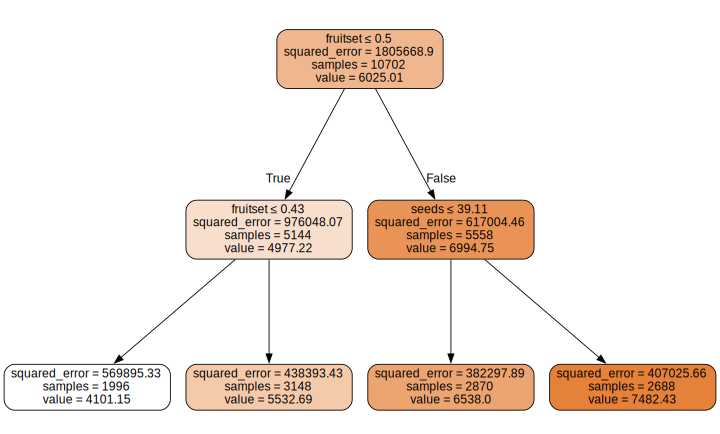

In [8]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
draw_tree(m, trn_xs, size=10)

We can confirm by checking summary statistics on the training set

In [9]:
df.iloc[train_idx].describe()

id  MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange  \
count  10702.000000      10702.000000      10702.000000          10702.000000   
mean    7702.377780         82.173631         49.678238             68.660306   
std     4402.141013          9.116424          5.527923              7.616654   
min        0.000000         69.700000         39.000000             58.200000   
25%     3889.000000         77.400000         46.800000             64.700000   
50%     7728.500000         86.000000         52.000000             71.900000   
75%    11534.500000         86.000000         52.000000             71.900000   
max    15286.000000         94.600000         57.200000             79.000000   

       MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange   RainingDays  \
count      10702.000000      10702.000000          10702.000000  10702.000000   
mean          59.236703         28.662325             48.571463     18.625544   
std            6.588857          3.184782              5.372659     11.627928   
min           50.200000         24.300000             41.200000      1.000000   
25%           55.800000         27.000000             45.800000     16.000000   
50%           62.000000         30.000000             50.800000     16.000000   
75%           62.000000         30.000000             50.800000     24.000000   
max           68.200000         33.000000             55.900000     34.000000   

       AverageRainingDays      fruitset     fruitmass         seeds  \
count        10702.000000  10702.000000  10702.000000  10702.000000   
mean             0.323463      0.503321      0.446766     36.164521   
std              0.163605      0.074883      0.037350      4.063566   
min              0.060000      0.226568      0.320727     23.412776   
25%              0.260000      0.458246      0.418220     33.116091   
50%              0.260000      0.506190      0.446522     36.001065   
75%              0.390000      0.563833      0.475425     39.160604   
max              0.560000      0.652144      0.535660     46.585105   

              yield  
count  10702.000000  
mean    6025.006863  
std     1343.814587  
min     1945.530610  
25%     5086.609910  
50%     6117.475900  
75%     7011.669170  
max     8969.401840

The next two nodes come from bisecting the dataset by values for fruitset above and below 0.5.

Alternative visualization using dtreeviz, showing the distribution of data along with the bisecting lines

In [10]:
dtreeviz.model(m, X_train=trn_xs, y_train=trn_y, feature_names=df.columns, target_name=dep_var).view()

c:\Users\Welp Windows 10\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


These previews were limited to just 4 nodes but now we will remove it

In [11]:
m = DecisionTreeRegressor()
m.fit(trn_xs, trn_y);

# Model performance evaluation
The Kaggle competition that this data was taken from will evaluate models based on mean absolute error

{{< katex >}}
`\(( MAE = \frac{1}{n}\sum_{i=1}^n|x_1 - y_1| \))`{=markdown}

where each `\\( x_i \\)`{=markdown} represents the predicted target, `\\( y_i \\)`{=markdown}  represents the ground truth, and `\\( n \\)`{=markdown} is the number of rows in the test set.

In [12]:
def mae(predictions, actuals):
    """calculate the mean absolute error between prediction and actual values

    Args:
        predictions (Series): from training set
        actuals (Series): from validation set

    Returns:
        _type_: float
    """
    return abs(predictions - actuals).sum() / len(predictions)

Generating our predictions from the model and taking the MAE:

In [13]:
predictions = m.predict(trn_xs)
mae(predictions, trn_y)

0.0

Checking it against our validation set:

In [14]:
mae(m.predict(valid_xs), valid_y)

265.16832584729707

A mean absolute error of 0 indicates overfitting, as the default setting for sklearn is to continue splitting nodes until they run out. The total nodes, or leaves, in the tree is almost as high as the total rows in the training set:

In [15]:
m.get_n_leaves(), len(trn_xs)

(7389, 10702)

Changing it to 25 modes will fix the problem, bringing the MAE closer to the validation set.

In [16]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(trn_xs, trn_y)
mae(m.predict(trn_xs), trn_y)
mae(m.predict(trn_xs), trn_y)

325.82382877172296

# Tree becomes forest
Decision trees offer a balance of generalization and accuracy, but they are on opposite ends of a fulcrum. Limiting the size of the tree means it generalizes well at the expense of accuracy and vice versa. To overcome this compromise, data scientists started using a new technique called random forests, extending the analogy. The intuition behind random forests echoes the central limit theorem: an aggregated measure derived from several samples is more accurate than any of the individual samples. However, random forests has specific criteria
- subset and bootstrap data from the training set
- randomly use different subsets of columns when choosing splits in each decision tree

Creating a random forest will be similar to the decision trees from earlier

In [17]:
def rf(xs, y, n_estimators=40, max_samples=2000, max_features=0.5, min_samples_leaf=5, **kwargs):
    """generate a random forest

    Args:
        xs (DataFrame): independent variables
        y (Series): dependent variable
        n_estimators (int, optional): number of trees. Defaults to 40.
        max_samples (_type_, optional): rows to sample for training each tree. Defaults to 2000.
        max_features (float, optional): number of columns to sample at each node. Defaults to 0.5, meaning half.
        min_samples_leaf (int, optional): minimum number of samples in each leaf. Defaults to 5.

    Returns:
        _type_: _description_
    """
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

Comparing the training results to the validation set

In [18]:
m = rf(trn_xs, trn_y)
mae(m.predict(trn_xs), trn_y), mae(m.predict(valid_xs), valid_y)

(313.41110995468966, 341.41466498564176)